Using device: xpu

Experiment Complete. Data saved.
    dim  n_train  nn_error     nn_time  ginn_error   ginn_time
0     2       50  0.084839   10.726271    0.031997   14.223401
1     2      100  0.057597    8.481767    0.020214   13.852328
2     2      200  0.020689    7.490827    0.008627   13.157578
3     2      400  0.012672    2.963829    0.007780    5.218217
4     2      800  0.012914    3.206660    0.005778    5.232867
5     2     1600  0.004117    3.854894    0.003643    5.444334
6     2     3200  0.003723    3.817886    0.003254    5.679569
7     2     6400  0.002875    3.777213    0.003433    7.106645
8     2    12800  0.003369    5.289873    0.002699    9.552202
9     2    25600  0.003358    7.237469    0.002646   15.632176
10    2    51200  0.003205   13.255467    0.002846   27.692409
11    2   102400  0.003280   22.351034    0.003184   51.153175
12    2   256000  0.003249   53.937793    0.003045  122.954069
13    5       50  0.444913    3.588579    0.271914    5.635525
14 

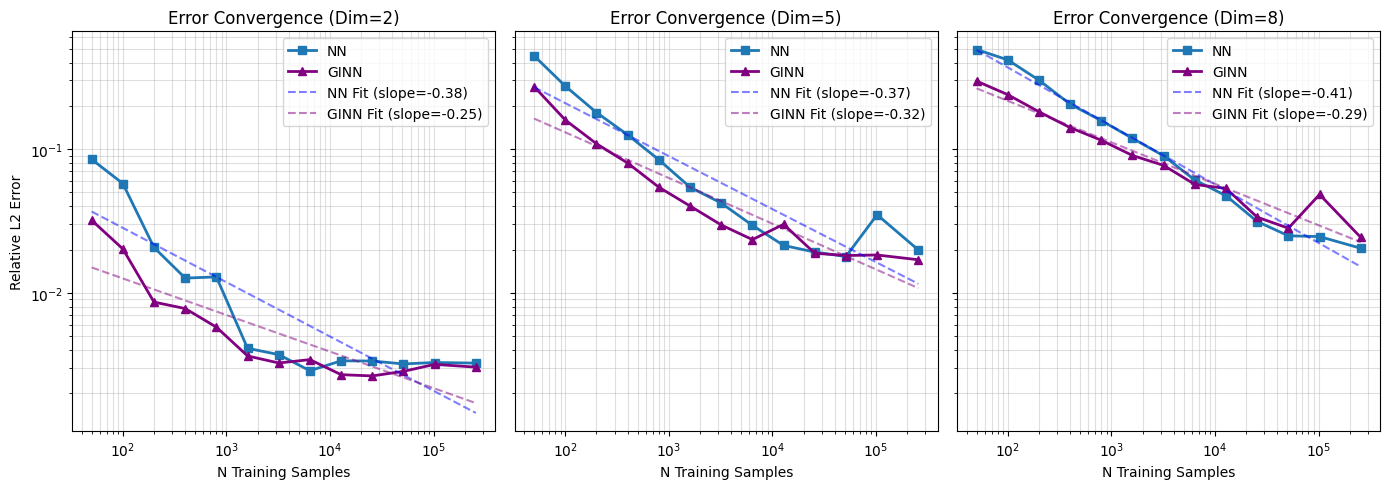

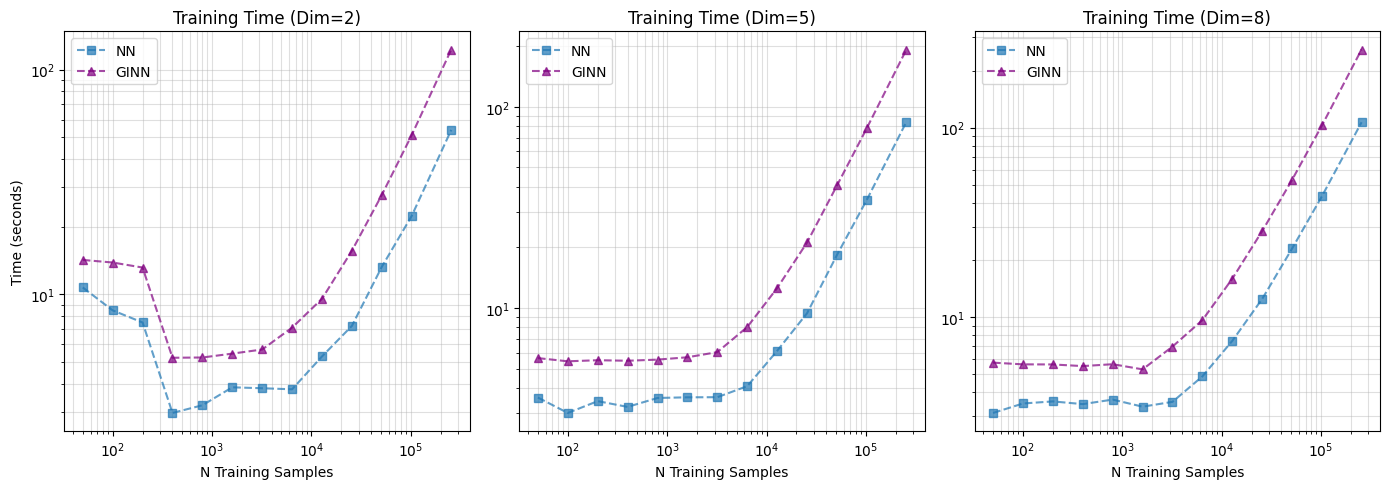

In [ ]:
import json
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# --- Configuration ---
SEED = 42
ROSENBROCK_SCALE = 100.0
TINY_EPS = 1e-8
DOMAIN = (-2, 2)
N_TEST = 1000

# Device configuration
device = "xpu" if torch.xpu.is_available() else "cpu"
print(f"Using device: {device}")

# Directory Setup
RESULTS_DIR = Path("results/rosenbrock_experiment_nn_ginn")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

N_TEST = 50_000
# Sweep Parameters
N_TRAIN_VALUES = [
    50,
    100,
    200,
    400,
    800,
    1600,
    3200,
    6400,
    12800,
    25600,
    51200,
    102400,
    256000,
]
DIM_VALUES = [2, 5, 8]

np.random.seed(SEED)
torch.manual_seed(SEED)


def rosenbrock(X: np.ndarray, a: float = ROSENBROCK_SCALE) -> np.ndarray:
    if X.ndim == 1:
        X = X.reshape(1, -1)
    x_i = X[:, :-1]
    x_next = X[:, 1:]
    F = np.sum(
        a * (x_next - x_i**2.0) ** 2.0 + (1.0 - x_i) ** 2.0, axis=1, keepdims=True
    )
    return F


def rosenbrock_grad(X: np.ndarray, a: float = ROSENBROCK_SCALE) -> np.ndarray:
    """
    Computes the gradient of the Rosenbrock function for given input points.

    Returns:
        J: (N, d) Jacobian at X
    """
    N, d = X.shape
    J = np.zeros((N, d), dtype=X.dtype)

    J[:, :-1] += 2 * (X[:, :-1] - 1)
    J[:, :-1] -= 4 * a * X[:, :-1] * (X[:, 1:] - X[:, :-1] ** 2)
    J[:, 1:] += 2 * a * (X[:, 1:] - X[:, :-1] ** 2)
    return J


def get_metrics(y_pred, y_true):
    diff = y_pred - y_true
    norm_diff = np.linalg.norm(diff)
    norm_gt = np.linalg.norm(y_true)
    l2_rel = float(norm_diff / (norm_gt + TINY_EPS))
    return l2_rel


# --- Models ---
class DynamicNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        width = max(64, 16 * input_dim)
        print(f"Building NN with input_dim={input_dim}, width={width}")
        self.net = nn.Sequential(
            nn.Linear(input_dim, width),
            nn.ReLU(),
            nn.Linear(width, width),
            nn.ReLU(),
            nn.Linear(width, width),
            nn.ReLU(),
            nn.Linear(width, 1),
        )

    def forward(self, x):
        return self.net(x)


def train_eval_nn(X_train, y_train, X_test, dim, epochs=2000):
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()

    X_tr_s = scaler_x.fit_transform(X_train)
    y_tr_s = scaler_y.fit_transform(y_train).reshape(-1, 1)
    X_te_s = scaler_x.transform(X_test)

    X_tr_th = torch.tensor(X_tr_s, dtype=torch.float32, device=device)
    y_tr_th = torch.tensor(y_tr_s, dtype=torch.float32, device=device)
    X_te_th = torch.tensor(X_te_s, dtype=torch.float32, device=device)

    model = DynamicNN(dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "min", patience=100, factor=0.5
    )
    criterion = nn.MSELoss()

    t0 = time.time()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(X_tr_th)
        loss = criterion(out, y_tr_th)
        loss.backward()
        optimizer.step()
        scheduler.step(loss.item())

    # Synchronize for accurate timing
    if device == "xpu":
        torch.xpu.synchronize()
    train_time = time.time() - t0

    model.eval()
    with torch.no_grad():
        y_pred_s = model(X_te_th).cpu().numpy()
    return scaler_y.inverse_transform(y_pred_s), train_time


def train_eval_ginn(X_train, y_train, X_test, dim, epochs=2000):
    """Neural Net trained with Value + Gradient supervision."""
    # 1. Generate True Gradients for Training Set
    grad_train = rosenbrock_grad(X_train)

    # 2. Scaling Logic
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()

    X_tr_s = scaler_x.fit_transform(X_train)
    y_tr_s = scaler_y.fit_transform(y_train).reshape(-1, 1)
    X_te_s = scaler_x.transform(X_test)

    # Calculate Scaling Factors for Gradient: d_hat/dx_hat = (std_x / std_y) * dy/dx
    # because y = std_y * y_hat + mu_y  => dy = std_y * dy_hat
    #         x = std_x * x_hat + mu_x  => dx = std_x * dx_hat
    std_x = torch.tensor(scaler_x.scale_, dtype=torch.float32, device=device)
    std_y = torch.tensor(scaler_y.scale_, dtype=torch.float32, device=device)

    X_tr_th = torch.tensor(
        X_tr_s, dtype=torch.float32, device=device, requires_grad=True
    )
    y_tr_th = torch.tensor(y_tr_s, dtype=torch.float32, device=device)
    grad_tr_th = torch.tensor(grad_train, dtype=torch.float32, device=device)
    X_te_th = torch.tensor(X_te_s, dtype=torch.float32, device=device)

    model = DynamicNN(dim).to(device)
    optimizer = optim.Adam(
        model.parameters(), lr=0.005
    )  # Slightly lower LR for stability
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "min", patience=100, factor=0.5
    )

    t0 = time.time()
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Forward
        y_pred = model(X_tr_th)

        # Gradient Computation (AutoDiff of the NN)
        # create_graph=True is essential for higher-order derivatives (loss involves grad)
        grads = torch.autograd.grad(
            outputs=y_pred,
            inputs=X_tr_th,
            grad_outputs=torch.ones_like(y_pred),
            create_graph=True,
        )[0]

        # Scale the true gradients to match the normalized space
        # True: dy/dx. Network predicts: dy_hat/dx_hat
        # Relation: dy_hat/dx_hat = (std_x / std_y) * dy/dx
        target_grads = (std_x / std_y) * grad_tr_th

        # Loss = MSE_Value + lambda * MSE_Grad
        loss_val = nn.MSELoss()(y_pred, y_tr_th)
        loss_grad = nn.MSELoss()(grads, target_grads)
        loss = loss_val + 0.1 * loss_grad  # Weighting factor for gradients

        loss.backward()
        optiWhatmizer.step()
        scheduler.step(loss.item())

    # Synchronize for accurate timing
    if device == "xpu":
        torch.xpu.synchronize()
    train_time = time.time() - t0

    model.eval()
    with torch.no_grad():
        y_pred_s = model(X_te_th).cpu().numpy()
    return scaler_y.inverse_transform(y_pred_s), train_time


# --- Main Experiment Logic ---
def run_experiment_or_load(dim, n_train, X_test_global, y_test_global):
    filename = RESULTS_DIR / f"D{dim}_N{n_train}.json"

    if filename.exists():
        with open(filename, "r") as f:
            data = json.load(f)
        return data

    # Run Experiment
    print(f"Running Experiment: Dim={dim}, N={n_train}")

    # Generate Training Data
    X_train = np.random.uniform(DOMAIN[0], DOMAIN[1], size=(n_train, dim))
    y_train = rosenbrock(X_train)

    # 1. NN
    y_nn, t_nn = train_eval_nn(X_train, y_train, X_test_global, dim)
    err_nn = get_metrics(y_nn, y_test_global)

    # 2. ginn (Grad-Enhanced)
    y_ginn, t_ginn = train_eval_ginn(X_train, y_train, X_test_global, dim)
    err_ginn = get_metrics(y_ginn, y_test_global)

    results = {
        "dim": dim,
        "n_train": n_train,
        "nn_error": err_nn,
        "nn_time": t_nn,
        "ginn_error": err_ginn,
        "ginn_time": t_ginn,
    }

    with open(filename, "w") as f:
        json.dump(results, f, indent=4)

    return results


# --- Driver Code ---

all_results = []

for d in DIM_VALUES:
    # Fixed Test Set
    X_test = np.random.uniform(DOMAIN[0], DOMAIN[1], size=(N_TEST, d))
    y_test = rosenbrock(X_test)

    for n in N_TRAIN_VALUES:
        res = run_experiment_or_load(d, n, X_test, y_test)
        all_results.append(res)

# Export to CSV
df = pd.DataFrame(all_results)
df.to_csv(RESULTS_DIR / "final_results.csv", index=False)
print("\nExperiment Complete. Data saved.")
print(df)

# --- Plotting ---

# Plot 1: Error Convergence (Fit a linear trend on log-log scale)
fig, axes = plt.subplots(1, len(DIM_VALUES), figsize=(14, 5), sharey=True)
if len(DIM_VALUES) == 1:
    axes = [axes]

for i, d in enumerate(DIM_VALUES):
    sub = df[df["dim"] == d]
    ax = axes[i]

    ax.loglog(sub["n_train"], sub["nn_error"], "s-", label="NN", lw=2)
    ax.loglog(
        sub["n_train"],
        sub["ginn_error"],
        "^-",
        label="GINN",
        lw=2,
        color="purple",
    )

    # Fit linear trends on log-log data
    for method, marker, color in [
        ("nn_error", "s", "blue"),
        ("ginn_error", "^", "purple"),
    ]:
        X_log = np.log10(sub["n_train"].values).reshape(-1, 1)
        y_log = np.log10(sub[method].values).reshape(-1, 1)
        reg = LinearRegression().fit(X_log, y_log)
        slope = reg.coef_[0][0]
        intercept = reg.intercept_[0]
        x_fit = np.linspace(
            np.log10(min(sub["n_train"])), np.log10(max(sub["n_train"])), 100
        )
        y_fit = slope * x_fit + intercept
        ax.plot(
            10**x_fit,
            10**y_fit,
            linestyle="--",
            color=color,
            alpha=0.5,
            label=f"{method.split('_')[0].upper()} Fit (slope={slope:.2f})",
        )

    ax.set_title(f"Error Convergence (Dim={d})")
    ax.set_xlabel("N Training Samples")
    if i == 0:
        ax.set_ylabel("Relative L2 Error")
    ax.grid(True, which="both", alpha=0.4)
    ax.legend()

plt.tight_layout()
plt.savefig(RESULTS_DIR / "error_plot.png")
plt.show()

# Plot 2: Training Time
fig, axes = plt.subplots(1, len(DIM_VALUES), figsize=(14, 5), sharey=False)
if len(DIM_VALUES) == 1:
    axes = [axes]

for i, d in enumerate(DIM_VALUES):
    sub = df[df["dim"] == d]
    ax = axes[i]

    ax.loglog(sub["n_train"], sub["nn_time"], "s--", label="NN", alpha=0.7)
    ax.loglog(
        sub["n_train"], sub["ginn_time"], "^--", label="GINN", alpha=0.7, color="purple"
    )

    ax.set_title(f"Training Time (Dim={d})")
    ax.set_xlabel("N Training Samples")
    if i == 0:
        ax.set_ylabel("Time (seconds)")
    ax.grid(True, which="both", alpha=0.4)
    ax.legend()

plt.tight_layout()
plt.savefig(RESULTS_DIR / "time_plot.png")
plt.show()